# Connect to the service

In [1]:
# only run on first load
# pip install trading-ig munch tenacity
from trading_ig.config import config

can't import config from config file


In [2]:
# Connecting to the service
from trading_ig.config import config
from trading_ig.rest import IGService

# Import information to convert the data to a data frame
import pandas as pd
# Import packages to save to CSV & JSON
import json, csv, os
# import time module for timestamps
from datetime import datetime, timedelta, date
import time

In [3]:
# Resolution offset 
from pandas.tseries.frequencies import to_offset

In [4]:
# cache session information and data 
import requests_cache
expire_after = timedelta(hours=1)
session = requests_cache.CachedSession(
    cache_name="cache", backend="sqlite", expire_after=expire_after)

In [5]:
# Connect to the data service api 
ig_service = IGService(config.username, config.password, config.api_key)
ig = ig_service.create_session()

In [6]:
# List of indeces starting with a single index
epics = {
    # "FTSE 100": "IX.D.FTSE.DAILY.IP",
    # "DAX 30": "IX.D.DAX.DAILY.IP",
    "Dow Jones": "IX.D.DOW.DAILY.IP",
    # "S&P 500": "IX.D.SPTRD.DAILY.IP",
    # "Nasdaq": "IX.D.NASDAQ.DAILY.IP",
}

epics

{'Dow Jones': 'IX.D.DOW.DAILY.IP'}

In [7]:
# Create a data varible to store results of the data export
data_folder = 'data'
historical_prices = {}

# Data by days
This call gets data based on the number of days

In [8]:
# Define the start date range for the historical prices
start_date = datetime.now() - timedelta(days=1)
s_date = start_date.strftime('%Y-%m-%dT%H:%M:%S')
# s_date = '2023-01-07'

print(s_date)

# Define the end date range 
end_date = datetime.now()
e_date = end_date.strftime('%Y-%m-%dT%H:%M:%S')
# e_date = '2023-02-23'

print(e_date)

# Define the interval for the historical prices

resolution= "1Min"

2023-03-05T15:01:03
2023-03-06T15:01:03


# Data by Days API CALL
This api call gets data by number of days, and can get large data sets exceeding the data call limits

In [9]:
# # # Fetch historical prices by determining the date range 

# # for index, epic in epics.items():
# #     result = ig_service.fetch_historical_prices_by_epic(
# #         epic = epic,
# #         start_date = f'{s_date}',
# #         end_date = f'{e_date}',
# #         resolution = f'{resolution}',
# #         pagesize= 1
# #         )
# #     # Use the following data for the parameters
# #     # epic: Any,
# #     # resolution: Any | None = None,
# #     # start_date: Any | None = None,
# #     # end_date: Any | None = None,
# #     # numpoints: Any | None = None,
# #     # pagesize: int = 20,
# #     # session: Any | None = None,
# #     # format: Any | None = None,
# #     # wait: int = 1
# #     print(result)
# #     prices = result['prices']
    
# #     # Getting todays date & time 
# #     # datetime.today().strftime('%Y-%m-%d %H:%M:%S')
    
# #     # Save the results to a folder
    
# #     os.makedirs(f'{data_folder}/{str(date.today())}', exist_ok=True)  
# #     prices.to_csv(f'{data_folder}/{str(date.today())}/data_{datetime.now()}.csv')  
# #     # # print(prices)
# #     # historical_prices[epic] = prices

# price data by number of points 
Extract and store data from the last 1000 data points

In [11]:
# change the number of data points to increase the information available
num_points = 1000

# if you want to cache this query
for index, epic in epics.items():
    response = ig_service.fetch_historical_prices_by_epic_and_num_points(epic, resolution, num_points)
    # Store raw prices to a local file
    df_prices = response['prices']
    df_prices.to_csv(f'data/dow-resolution-{resolution}-date-{e_date}.csv')
    print(response)
    df_prices.head()

{'prices':                          bid                                 ask           \
                        Open     High      Low    Close     Open     High   
DateTime                                                                    
2023-03-03 21:24:00  33396.1  33399.1  33396.1  33398.6  33400.9  33403.9   
2023-03-03 21:25:00  33398.1  33398.6  33397.1  33397.6  33402.9  33403.4   
2023-03-03 21:26:00  33397.1  33404.6  33396.6  33404.6  33401.9  33409.4   
2023-03-03 21:27:00  33404.1  33407.6  33401.1  33403.6  33408.9  33412.4   
2023-03-03 21:28:00  33403.1  33403.1  33397.6  33398.6  33407.9  33407.9   
...                      ...      ...      ...      ...      ...      ...   
2023-03-06 14:59:00  33440.3  33444.3  33436.8  33443.3  33442.7  33446.7   
2023-03-06 15:00:00  33442.8  33446.3  33422.8  33422.8  33445.2  33448.7   
2023-03-06 15:01:00  33423.8  33440.3  33414.3  33427.8  33426.2  33442.7   
2023-03-06 15:02:00  33428.3  33443.3  33423.8  33443.3  33430.7 

# Transform files
store the files downloaded to a local folder
- Trim columns to remove last values and only keep volume data
- Trim the number of columns to get bid, ask & volume only 

In [12]:
volume =  df_prices['last']
volume = volume.drop(columns=['Open','High', 'Low', 'Close'])
volume.head()

,Volume
DateTime,
2023-03-03 21:24:00,20
2023-03-03 21:25:00,9
2023-03-03 21:26:00,23
2023-03-03 21:27:00,51
2023-03-03 21:28:00,24


In [13]:
# create a dataframe for the bid & ask
bid_ask_data = df_prices[['bid', 'ask']]

# Combine the two data sources
clean_data = pd.concat([bid_ask_data, volume], axis=1)

clean_data.head()

,"(bid, Open)","(bid, High)","(bid, Low)","(bid, Close)","(ask, Open)","(ask, High)","(ask, Low)","(ask, Close)",Volume
DateTime,,,,,,,,,
2023-03-03 21:24:00,33396.1,33399.1,33396.1,33398.6,33400.9,33403.9,33400.9,33403.4,20
2023-03-03 21:25:00,33398.1,33398.6,33397.1,33397.6,33402.9,33403.4,33401.9,33402.4,9
2023-03-03 21:26:00,33397.1,33404.6,33396.6,33404.6,33401.9,33409.4,33401.4,33409.4,23
2023-03-03 21:27:00,33404.1,33407.6,33401.1,33403.6,33408.9,33412.4,33405.9,33408.4,51
2023-03-03 21:28:00,33403.1,33403.1,33397.6,33398.6,33407.9,33407.9,33402.4,33403.4,24


In [14]:
# view the column headings 
list(clean_data.columns)

# rename the columns 
clean_data_2 = clean_data.rename(columns = {
    ('bid', 'Open'):'bid-open',
    ('bid', 'High'): 'bid-high',
    ('bid', 'Low'): 'bid-low',
    ('bid', 'Close'): 'bid-close',
    ('ask', 'Open'): 'ask-open',
    ('ask', 'High'): 'ask-high',
    ('ask', 'Low'): 'ask-low',
    ('ask', 'Close'): 'ask-close'
                                           })
clean_data_2.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-03 21:24:00,33396.1,33399.1,33396.1,33398.6,33400.9,33403.9,33400.9,33403.4,20
2023-03-03 21:25:00,33398.1,33398.6,33397.1,33397.6,33402.9,33403.4,33401.9,33402.4,9
2023-03-03 21:26:00,33397.1,33404.6,33396.6,33404.6,33401.9,33409.4,33401.4,33409.4,23
2023-03-03 21:27:00,33404.1,33407.6,33401.1,33403.6,33408.9,33412.4,33405.9,33408.4,51
2023-03-03 21:28:00,33403.1,33403.1,33397.6,33398.6,33407.9,33407.9,33402.4,33403.4,24
...,...,...,...,...,...,...,...,...,...
2023-03-06 14:59:00,33440.3,33444.3,33436.8,33443.3,33442.7,33446.7,33439.2,33445.7,324
2023-03-06 15:00:00,33442.8,33446.3,33422.8,33422.8,33445.2,33448.7,33425.2,33425.2,472
2023-03-06 15:01:00,33423.8,33440.3,33414.3,33427.8,33426.2,33442.7,33416.7,33430.2,397


In [15]:
clean_data_2.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-03 21:24:00,33396.1,33399.1,33396.1,33398.6,33400.9,33403.9,33400.9,33403.4,20
2023-03-03 21:25:00,33398.1,33398.6,33397.1,33397.6,33402.9,33403.4,33401.9,33402.4,9
2023-03-03 21:26:00,33397.1,33404.6,33396.6,33404.6,33401.9,33409.4,33401.4,33409.4,23
2023-03-03 21:27:00,33404.1,33407.6,33401.1,33403.6,33408.9,33412.4,33405.9,33408.4,51
2023-03-03 21:28:00,33403.1,33403.1,33397.6,33398.6,33407.9,33407.9,33402.4,33403.4,24


# Save cleaned data
Save prices to a local folder

In [16]:
# Save to Json
clean_data_2.to_json(f'data/cleaned/dow-resolution-{resolution}-date-{e_date}.json')
# Save to csv
clean_data_2.to_csv(f'data/cleaned/dow-resolution-{resolution}-date-{e_date}.csv')

In [17]:
clean_data_2.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-03 21:24:00,33396.1,33399.1,33396.1,33398.6,33400.9,33403.9,33400.9,33403.4,20
2023-03-03 21:25:00,33398.1,33398.6,33397.1,33397.6,33402.9,33403.4,33401.9,33402.4,9
2023-03-03 21:26:00,33397.1,33404.6,33396.6,33404.6,33401.9,33409.4,33401.4,33409.4,23
2023-03-03 21:27:00,33404.1,33407.6,33401.1,33403.6,33408.9,33412.4,33405.9,33408.4,51
2023-03-03 21:28:00,33403.1,33403.1,33397.6,33398.6,33407.9,33407.9,33402.4,33403.4,24


# Chart the data


In [30]:
data = clean_data_2
data.head()

,bid-open,bid-high,bid-low,bid-close,ask-open,ask-high,ask-low,ask-close,Volume
DateTime,,,,,,,,,
2023-03-03 21:24:00,33396.1,33399.1,33396.1,33398.6,33400.9,33403.9,33400.9,33403.4,20
2023-03-03 21:25:00,33398.1,33398.6,33397.1,33397.6,33402.9,33403.4,33401.9,33402.4,9
2023-03-03 21:26:00,33397.1,33404.6,33396.6,33404.6,33401.9,33409.4,33401.4,33409.4,23
2023-03-03 21:27:00,33404.1,33407.6,33401.1,33403.6,33408.9,33412.4,33405.9,33408.4,51
2023-03-03 21:28:00,33403.1,33403.1,33397.6,33398.6,33407.9,33407.9,33402.4,33403.4,24


In [36]:
# Delete unnecessary columns
# Return the following collumn values
chart_data = data.loc[:, ['bid-open', 'bid-high', 'bid-low', 'bid-close', 'Volume']]

chart_data = chart_data.rename(columns = {
    'bid-open':'open',
    'bid-high':'high',
    'bid-low':'low',
    'bid-close':'close',
    'Volume': 'volume'
                      })
chart_data.head()

,open,high,low,close,volume
DateTime,,,,,
2023-03-03 21:24:00,33396.1,33399.1,33396.1,33398.6,20
2023-03-03 21:25:00,33398.1,33398.6,33397.1,33397.6,9
2023-03-03 21:26:00,33397.1,33404.6,33396.6,33404.6,23
2023-03-03 21:27:00,33404.1,33407.6,33401.1,33403.6,51
2023-03-03 21:28:00,33403.1,33403.1,33397.6,33398.6,24


In [37]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

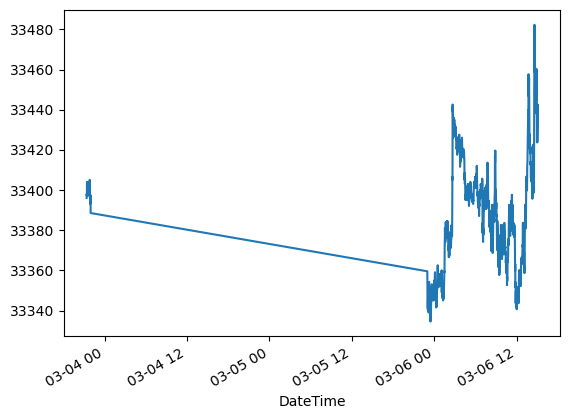

In [42]:
# Plot adjusted close price data
chart_data['open'].plot()
plt.show()

In [43]:
# Plotting candlestick 

In [44]:
import plotly.graph_objects as go
from datetime import datetime

import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [49]:
# Define a figure
# Charts work better with minute data

chart = go.Figure()

# add a trace for a Candlestick graph
chart.add_trace(go.Candlestick())

# Map each column to the correct value from the downloaded data
chart.add_trace(go.Candlestick(
    x=chart_data.index,
    open = chart_data['open'], 
    high=chart_data['high'], 
    low=chart_data['low'], 
    close=chart_data['close'], 
    name = 'market data'))


# Include shortcut buttons
chart.update_xaxes( rangeslider_visible=False, rangeselector=dict(
    buttons=list([
        dict(count=1, label='1 Period', step="hour", stepmode="backward"),
        dict(count=5, label='5 Periods', step="hour", stepmode="backward"),
        #dict(count=6, label='6 Periods', step="hour", stepmode="backward"),
        dict(count=10, label='10 Periods', step="hour", stepmode="backward"),
        dict(count=30, label='30 Periods', step="hour", stepmode="backward"),
        dict(step="all") 
    ]) 
))
chart.show()

In [59]:
# Plot moving averages on the chart
chart_data['MA50'] = chart_data['close'].rolling(window=50, min_periods=0).mean()
chart_data['MA200'] = chart_data['close'].rolling(window=200, min_periods=0).mean()
chart_data['MA200'].head(30)

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.10, subplot_titles=(f'{epics}-Price Chart', 'Volume'), 
               row_width=[0.2, 0.7])

#Bottom chart displaying similar price data 
fig.add_trace(go.Candlestick(x=chart_data.index, open=chart_data["open"], high=chart_data["high"],
                low=chart_data["low"], close=chart_data["close"], name="OHLC"), 
                row=1, col=1)
#Price chart - 50 day moving average 
fig.add_trace(go.Scatter(x=chart_data.index, y=chart_data["MA50"], marker_color='grey',name="MA50"), row=1, col=1)

# Sub chart - 200 day moving average
fig.add_trace(go.Scatter(x=chart_data.index, y=chart_data["MA200"], marker_color='lightgrey',name="MA200"), row=1, col=1)

# no volume data exists
fig.add_trace(go.Bar(x=chart_data.index, y=chart_data['volume'], marker_color='red', showlegend=False), row=2, col=1)


In [71]:
# Retrieve the Goolge stock data from Yahoo finance
data = chart_data
data.tail()

,open,high,low,close,volume,MA50,MA200
DateTime,,,,,,,
2023-03-06 14:59:00,33440.3,33444.3,33436.8,33443.3,324,33431.680,33394.0275
2023-03-06 15:00:00,33442.8,33446.3,33422.8,33422.8,472,33432.022,33394.2255
2023-03-06 15:01:00,33423.8,33440.3,33414.3,33427.8,397,33432.484,33394.4535
2023-03-06 15:02:00,33428.3,33443.3,33423.8,33443.3,263,33433.226,33394.7690
2023-03-06 15:03:00,33442.3,33456.3,33442.3,33454.3,197,33434.248,33395.1420


In [73]:

# Compute the Bollinger Bands 
def BBANDS(data, window=n):
    MA = data.close.rolling(window=n).mean()
    SD = data.close.rolling(window=n).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

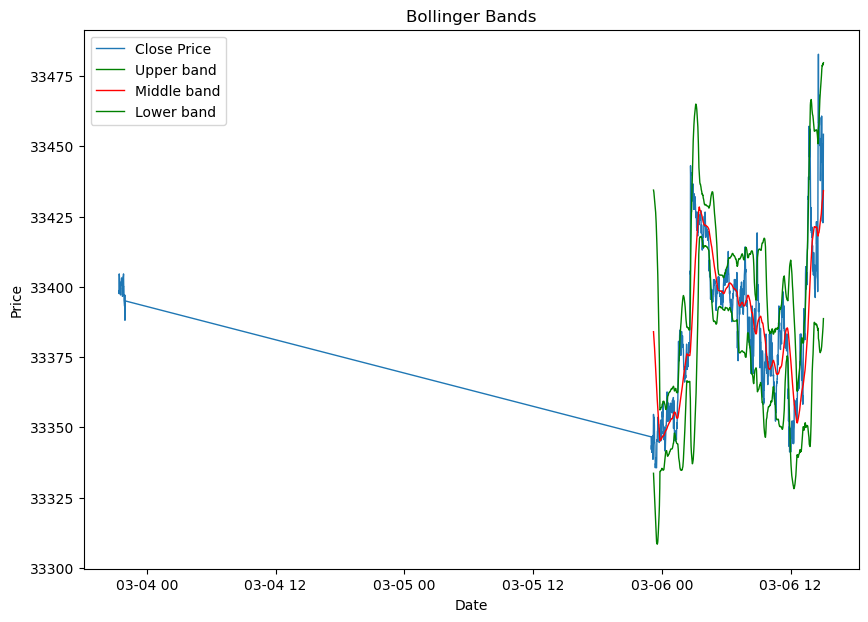

In [74]:
 
# Compute the Bollinger Bands for the stock using the 50-day Moving average
n = 50

BBANDS = BBANDS(data, n)

# Create the plot
# pd.concat([BBANDS.Close, BBANDS.UpperBB, BBANDS.LowerBB],axis=1).plot(figsize=(9,5),)

plt.figure(figsize=(10,7))

# Set the title and axis labels
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(BBANDS.close,lw=1, label='Close Price')
plt.plot(data['UpperBand'],'g',lw=1, label='Upper band')
plt.plot(data['MiddleBand'],'r',lw=1, label='Middle band')
plt.plot(data['LowerBand'],'g', lw=1, label='Lower band')

# Add a legend to the axis
plt.legend()

plt.show()